# Transformer Network Application: Named-Entity Recognition

Welcome to Week 4's second ungraded lab. In this notebook you'll explore one application of the transformer architecture that you built in the previous assignment.

**After this assignment you'll be able to**:

* Use tokenizers and pre-trained models from the HuggingFace Library.
* Fine-tune a pre-trained transformer model for Named-Entity Recognition

## Table of Contents

- [Packages](#0)
- [1 - Named-Entity Recogniton to Process Resumes](#1)
    - [1.1 - Data Cleaning](#1-1)
    - [1.2 - Padding and Generating Tags](#1-2)
    - [1.3 - Tokenize and Align Labels with 🤗 Library](#1-3)
        - [Exercise 1 - tokenize_and_align_labels](#ex-1)
    - [1.4 - Optimization](#1-4)

<a name='0'></a>
## Packages

Run the following cell to load the packages you'll need.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import json
import random
import logging
import re

tf.get_logger().setLevel('ERROR')

<a name='1'></a>
## 1 - Named-Entity Recogniton to Process Resumes

When faced with a large amount of unstructured text data, named-entity recognition (NER) can help you detect and classify important information in your dataset. For instance, in the running example "Jane vists Africa in September", NER would help you detect "Jane", "Africa", and "September" as named-entities and classify them as person, location, and time. 

* You will use a variation of the Transformer model you built in the last assignment to process a large dataset of resumes.
* You will find and classify relavent information such as the companies the applicant worked at, skills, type of degree, etc. 

<a name='1-1'></a>
### 1.1 - Dataset Cleaning

In this assignment you will optimize a Transformer model on a dataset of resumes. Take a look at how the data you will be working with are structured.

In [2]:
df_data = pd.read_json("ner.json", lines=True)
df_data = df_data.drop(['extras'], axis=1)
df_data['content'] = df_data['content'].str.replace("\n", " ")

In [3]:
df_data.head()

,content,annotation
0,Abhishek Jha Application Development Associate...,"[{'label': ['Skills'], 'points': [{'start': 12..."
1,Afreen Jamadar Active member of IIIT Committee...,"[{'label': ['Email Address'], 'points': [{'sta..."
2,"Akhil Yadav Polemaina Hyderabad, Telangana - E...","[{'label': ['Skills'], 'points': [{'start': 37..."
3,Alok Khandai Operational Analyst (SQL DBA) Eng...,"[{'label': ['Skills'], 'points': [{'start': 80..."
4,Ananya Chavan lecturer - oracle tutorials Mum...,"[{'label': ['Degree'], 'points': [{'start': 20..."


In [4]:
df_data.iloc[0]['annotation']

[{'label': ['Skills'],
  'points': [{'start': 1295,
    'end': 1621,
    'text': '\n• Programming language: C, C++, Java\n• Oracle PeopleSoft\n• Internet Of Things\n• Machine Learning\n• Database Management System\n• Computer Networks\n• Operating System worked on: Linux, Windows, Mac\n\nNon - Technical Skills\n\n• Honest and Hard-Working\n• Tolerant and Flexible to Different Situations\n• Polite and Calm\n• Team-Player'}]},
 {'label': ['Skills'],
  'points': [{'start': 993,
    'end': 1153,
    'text': 'C (Less than 1 year), Database (Less than 1 year), Database Management (Less than 1 year),\nDatabase Management System (Less than 1 year), Java (Less than 1 year)'}]},
 {'label': ['College Name'],
  'points': [{'start': 939, 'end': 956, 'text': 'Kendriya Vidyalaya'}]},
 {'label': ['College Name'],
  'points': [{'start': 883, 'end': 904, 'text': 'Woodbine modern school'}]},
 {'label': ['Graduation Year'],
  'points': [{'start': 856, 'end': 860, 'text': '2017\n'}]},
 {'label': ['College 

In [5]:
def mergeIntervals(intervals):
    sorted_by_lower_bound = sorted(intervals, key=lambda tup: tup[0])
    merged = []

    for higher in sorted_by_lower_bound:
        if not merged:
            merged.append(higher)
        else:
            lower = merged[-1]
            if higher[0] <= lower[1]:
                if lower[2] is higher[2]:
                    upper_bound = max(lower[1], higher[1])
                    merged[-1] = (lower[0], upper_bound, lower[2])
                else:
                    if lower[1] > higher[1]:
                        merged[-1] = lower
                    else:
                        merged[-1] = (lower[0], higher[1], higher[2])
            else:
                merged.append(higher)
    return merged

In [8]:
def get_entities(df):
    
    entities = []
    
    for i in range(len(df)):
        entity = []
    
        for annot in df['annotation'][i]:
            try:
                ent = annot['label'][0]
                start = annot['points'][0]['start']
                end = annot['points'][0]['end'] + 1
                entity.append((start, end, ent))
            except:
                pass
    
        entity = mergeIntervals(entity)
        entities.append(entity)
    
    return entities

In [9]:
df_data['entities'] = get_entities(df_data)
df_data.head()

,content,annotation,entities
0,Abhishek Jha Application Development Associate...,"[{'label': ['Skills'], 'points': [{'start': 12...","[(0, 12, Name), (13, 46, Designation), (49, 58..."
1,Afreen Jamadar Active member of IIIT Committee...,"[{'label': ['Email Address'], 'points': [{'sta...","[(0, 14, Name), (62, 68, Location), (104, 148,..."
2,"Akhil Yadav Polemaina Hyderabad, Telangana - E...","[{'label': ['Skills'], 'points': [{'start': 37...","[(0, 21, Name), (22, 31, Location), (65, 117, ..."
3,Alok Khandai Operational Analyst (SQL DBA) Eng...,"[{'label': ['Skills'], 'points': [{'start': 80...","[(0, 12, Name), (13, 51, Designation), (54, 60..."
4,Ananya Chavan lecturer - oracle tutorials Mum...,"[{'label': ['Degree'], 'points': [{'start': 20...","[(0, 13, Name), (14, 22, Designation), (24, 41..."


In [10]:
def convert_dataturks_to_spacy(dataturks_JSON_FilePath):
    try:
        training_data = []
        lines=[]
        with open(dataturks_JSON_FilePath, 'r') as f:
            lines = f.readlines()

        for line in lines:
            data = json.loads(line)
            text = data['content'].replace("\n", " ")
            entities = []
            data_annotations = data['annotation']
            if data_annotations is not None:
                for annotation in data_annotations:
                    #only a single point in text annotation.
                    point = annotation['points'][0]
                    labels = annotation['label']
                    # handle both list of labels or a single label.
                    if not isinstance(labels, list):
                        labels = [labels]

                    for label in labels:
                        point_start = point['start']
                        point_end = point['end']
                        point_text = point['text']
                        
                        lstrip_diff = len(point_text) - len(point_text.lstrip())
                        rstrip_diff = len(point_text) - len(point_text.rstrip())
                        if lstrip_diff != 0:
                            point_start = point_start + lstrip_diff
                        if rstrip_diff != 0:
                            point_end = point_end - rstrip_diff
                        entities.append((point_start, point_end + 1 , label))
            training_data.append((text, {"entities" : entities}))
        return training_data
    except Exception as e:
        logging.exception("Unable to process " + dataturks_JSON_FilePath + "\n" + "error = " + str(e))
        return None

def trim_entity_spans(data: list) -> list:
    """Removes leading and trailing white spaces from entity spans.

    Args:
        data (list): The data to be cleaned in spaCy JSON format.

    Returns:
        list: The cleaned data.
    """
    invalid_span_tokens = re.compile(r'\s')

    cleaned_data = []
    for text, annotations in data:
        entities = annotations['entities']
        valid_entities = []
        for start, end, label in entities:
            valid_start = start
            valid_end = end
            while valid_start < len(text) and invalid_span_tokens.match(
                    text[valid_start]):
                valid_start += 1
            while valid_end > 1 and invalid_span_tokens.match(
                    text[valid_end - 1]):
                valid_end -= 1
            valid_entities.append([valid_start, valid_end, label])
        cleaned_data.append([text, {'entities': valid_entities}])
    return cleaned_data  

In [11]:
data = trim_entity_spans(convert_dataturks_to_spacy("ner.json"))

In [12]:
from tqdm.notebook import tqdm
def clean_dataset(data):
    cleanedDF = pd.DataFrame(columns=["setences_cleaned"])
    sum1 = 0
    for i in tqdm(range(len(data))):
        start = 0
        emptyList = ["Empty"] * len(data[i][0].split())
        numberOfWords = 0
        lenOfString = len(data[i][0])
        strData = data[i][0]
        strDictData = data[i][1]
        lastIndexOfSpace = strData.rfind(' ')
        for i in range(lenOfString):
            if (strData[i]==" " and strData[i+1]!=" "):
                for k,v in strDictData.items():
                    for j in range(len(v)):
                        entList = v[len(v)-j-1]
                        if (start>=int(entList[0]) and i<=int(entList[1])):
                            emptyList[numberOfWords] = entList[2]
                            break
                        else:
                            continue
                start = i + 1  
                numberOfWords += 1
            if (i == lastIndexOfSpace):
                for j in range(len(v)):
                        entList = v[len(v)-j-1]
                        if (lastIndexOfSpace>=int(entList[0]) and lenOfString<=int(entList[1])):
                            emptyList[numberOfWords] = entList[2]
                            numberOfWords += 1
        cleanedDF = cleanedDF.append(pd.Series([emptyList],  index=cleanedDF.columns ), ignore_index=True )
        sum1 = sum1 + numberOfWords
    return cleanedDF

In [13]:
cleanedDF = clean_dataset(data)

Take a look at your cleaned dataset and the categories the named-entities are matched to, or 'tags'.

In [14]:
cleanedDF.head()

,setences_cleaned
0,"[Name, Name, Designation, Designation, Designa..."
1,"[Name, Name, Empty, Empty, Empty, Empty, Empty..."
2,"[Name, Name, Name, Empty, Empty, Empty, Empty,..."
3,"[Name, Name, Designation, Designation, Designa..."
4,"[Name, Name, Designation, Empty, Companies wor..."


<a name='1-2'></a>
### 1.2 - Padding and Generating Tags

Now, it is time to generate a list of unique tags you will match the named-entities to.

In [15]:
unique_tags = set(cleanedDF['setences_cleaned'].explode().unique())#pd.unique(cleanedDF['setences_cleaned'])#set(tag for doc in cleanedDF['setences_cleaned'].values.tolist() for tag in doc)
tag2id = {tag: id for id, tag in enumerate(unique_tags)}
id2tag = {id: tag for tag, id in tag2id.items()}

In [16]:
unique_tags

{'College Name',
 'Companies worked at',
 'Degree',
 'Designation',
 'Email Address',
 'Empty',
 'Graduation Year',
 'Location',
 'Name',
 'Skills',
 'UNKNOWN',
 'Years of Experience'}

Next, you will create an array of tags from your cleaned dataset. Oftentimes your input sequence will exceed the maximum length of a sequence your network can process. In this case, your sequence will be cut off, and you need to append zeroes onto the end of the shortened sequences using this [Keras padding API](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences).

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [18]:
MAX_LEN = 512
labels = cleanedDF['setences_cleaned'].values.tolist()

tags = pad_sequences([[tag2id.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2id["Empty"], padding="post",
                     dtype="long", truncating="post")

In [19]:
tags

array([[2, 2, 1, ..., 6, 6, 6],
       [2, 2, 6, ..., 6, 6, 6],
       [2, 2, 2, ..., 6, 8, 6],
       ...,
       [2, 2, 1, ..., 6, 6, 6],
       [2, 2, 1, ..., 6, 6, 6],
       [2, 2, 1, ..., 6, 6, 6]])

<a name='1-3'></a>
### 1.3 - Tokenize and Align Labels with 🤗 Library

Before feeding the texts to a Transformer model, you will need to tokenize your input using a [🤗 Transformer tokenizer](https://huggingface.co/transformers/main_classes/tokenizer.html). It is crucial that the tokenizer you use must match the Transformer model type you are using! In this exercise, you will use the 🤗 [DistilBERT fast tokenizer](https://huggingface.co/transformers/model_doc/distilbert.html), which standardizes the length of your sequence to 512 and pads with zeros. Notice this matches the maximum length you used when creating tags. 

In [20]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_virtual_device_configuration(gpu,[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])

In [21]:
from transformers import DistilBertTokenizerFast #, TFDistilBertModel
tokenizer = DistilBertTokenizerFast.from_pretrained('tokenizer/')

Transformer models are often trained by tokenizers that split words into subwords. For instance, the word 'Africa' might get split into multiple subtokens. This can create some misalignment between the list of tags for the dataset and the list of labels generated by the tokenizer, since the tokenizer can split one word into several, or add special tokens. Before processing, it is important that you align the lists of tags and the list of labels generated by the selected tokenizer with a `tokenize_and_align_labels()` function.

<a name='ex-1'></a>
### Exercise 1 - tokenize_and_align_labels

Implement `tokenize_and_align_labels()`. The function should perform the following:
* The tokenizer cuts sequences that exceed the maximum size allowed by your model with the parameter `truncation=True`
* Aligns the list of tags and labels with the tokenizer `word_ids` method returns a list that maps the subtokens to the original word in the sentence and special tokens to `None`. 
* Set the labels of all the special tokens (`None`) to -100 to prevent them from affecting the loss function. 
* Label of the first subtoken of a word and set the label for the following subtokens to -100. 

In [22]:
label_all_tokens = True
def tokenize_and_align_labels(tokenizer, examples, tags):
    tokenized_inputs = tokenizer(examples, truncation=True, is_split_into_words=False, padding='max_length', max_length=512)
    labels = []
    for i, label in enumerate(tags):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

Now that you have tokenized inputs, you can create train and test datasets!

In [23]:
test = tokenize_and_align_labels(tokenizer, df_data['content'].values.tolist(), tags)
train_dataset = tf.data.Dataset.from_tensor_slices((
    test['input_ids'],
    test['labels']
))

<a name='1-4'></a>
### 1.4 - Optimization

Fantastic! Now you can finally feed your data into into a pretrained 🤗 model. You will optimize a DistilBERT model, which matches the tokenizer you used to preprocess your data. Try playing around with the different hyperparamters to improve your results!

In [24]:
from transformers import TFDistilBertForTokenClassification

model = TFDistilBertForTokenClassification.from_pretrained('model/', num_labels=len(unique_tags))

All model checkpoint layers were used when initializing TFDistilBertForTokenClassification.

All the layers of TFDistilBertForTokenClassification were initialized from the model checkpoint at model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForTokenClassification for predictions without further training.


In [25]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy']) # can also use any keras loss fn
model.fit(train_dataset.batch(4),
          epochs=10, 
          batch_size=4)

Epoch 1/10
55/55 [==============================] - 5s 94ms/step - loss: 0.9223 - accuracy: 0.6907
Epoch 2/10
55/55 [==============================] - 5s 95ms/step - loss: 0.4665 - accuracy: 0.7538
Epoch 3/10
55/55 [==============================] - 5s 95ms/step - loss: 0.4286 - accuracy: 0.7605
Epoch 4/10
55/55 [==============================] - 5s 94ms/step - loss: 0.4068 - accuracy: 0.7619
Epoch 5/10
55/55 [==============================] - 5s 95ms/step - loss: 0.3864 - accuracy: 0.7627
Epoch 6/10
55/55 [==============================] - 5s 95ms/step - loss: 0.3674 - accuracy: 0.7638
Epoch 7/10
55/55 [==============================] - 5s 94ms/step - loss: 0.3475 - accuracy: 0.7651
Epoch 8/10
55/55 [==============================] - 5s 94ms/step - loss: 0.3273 - accuracy: 0.7704
Epoch 9/10
55/55 [==============================] - 5s 94ms/step - loss: 0.3100 - accuracy: 0.7756
Epoch 10/10
55/55 [==============================] - 5s 94ms/step - loss: 0.3048 - accuracy: 0.7756


In [26]:
text = "Manisha Bharti. 3.5 years of professional IT experience in Banking and Finance domain"
inputs = tokenizer(text, return_tensors="tf", truncation=True, is_split_into_words=False, padding="max_length", max_length=512 )
input_ids = inputs["input_ids"]
#inputs["labels"] = tf.reshape(tf.constant([1] * tf.size(input_ids).numpy()), (-1, tf.size(input_ids)))

In [27]:
output = model(inputs).logits
prediction = np.argmax(output, axis=2)
print( prediction)

[[6 2 2 2 2 2 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 6 6 6 6 6 2 6 6 6 6 6 6 6 6 6
  6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 2 2 2 6 6 6 6 6 6 6 6 6 6 6 6
  6 6 6 6 6 6 6 6 6 6 6 6 6 2 2 2 2 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
  6 6 6 2 2 2 2 2 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 2 2 2 6 6 6 6 6 6 6 6 6 6
  6 2 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 6 6 6 2 2 2 2
  6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 6 6 6 6 6 2 2 2 2
  6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 6 6 6 6 6 6 6 6 6 6
  6 2 2 2 2 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
  6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
  6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 2 2 2 6 6 6 6 6 6 6 6 6 6 6 6
  6 6 6 6 6 6 6 6 6 6 2 2 2 2 6 6 6 6 6 6 6 6 6 6 2 2 2 2 6 2 2 2 2 6 6 6
  2 2 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 2 2 2 2 2 2 6 6 6 6 6 6
  6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 6 6 6 2 2 2 2 2 6 6 6 6 6 6 6
  6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 

In [28]:
model(inputs)

TFTokenClassifierOutput(loss=None, logits=<tf.Tensor: shape=(1, 512, 12), dtype=float32, numpy=
array([[[-0.38189268,  0.45073137,  0.29383048, ..., -0.02313716,
          0.09695398, -0.4454521 ],
        [-0.29801923, -0.12251136,  2.6440022 , ..., -0.4091571 ,
         -0.50537753, -0.37157086],
        [-0.3157217 , -0.18611374,  2.5935278 , ..., -0.39706427,
         -0.4096334 , -0.49894658],
        ...,
        [-0.5684787 ,  0.14548619, -0.40093693, ..., -0.05900146,
         -0.28190082, -0.24942519],
        [-0.5190365 ,  0.18332979, -0.35658726, ..., -0.06386196,
         -0.27114925, -0.25307107],
        [-0.6063549 ,  0.16999994, -0.36715522, ..., -0.12903613,
         -0.310258  , -0.19223411]]], dtype=float32)>, hidden_states=None, attentions=None)

In [29]:
pred_labels = []

In [30]:
!pip install seqeval

     |████████████████████████████████| 43 kB 10.0 MB/s eta 0:00:01
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=17585 sha256=f282d87115cf1b76b14b748b9083f214340165d37cfdede18f25e9d35d910371
  Stored in directory: /root/.cache/pip/wheels/39/29/36/1c4f7905c133e11748ca375960154964082d4fb03478323089
Successfully built seqeval
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [31]:
true_labels = [[id2tag.get(true_index, "Empty") for true_index in test['labels'][i]] for i in range(len(test['labels']))]
np.array(true_labels).shape

(220, 512)

In [32]:
output = model.predict(train_dataset)

In [33]:
predictions = np.argmax(output['logits'].reshape(220, -1, 12), axis=-1)

In [34]:
predictions.shape

(220, 512)

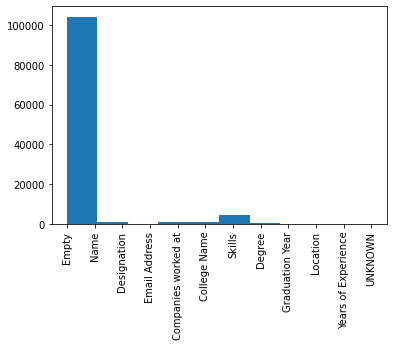

In [35]:
from matplotlib import pyplot as plt 

p = plt.hist(np.array(true_labels).flatten())
plt.xticks(rotation='vertical')
plt.show()

In [36]:
from collections import Counter
Counter(np.array(true_labels).flatten())

Counter({'Empty': 103155,
         'Name': 1035,
         'Designation': 1100,
         'Email Address': 76,
         'Companies worked at': 908,
         'College Name': 792,
         'Skills': 4704,
         'Degree': 598,
         'Graduation Year': 80,
         'Location': 116,
         'Years of Experience': 75,
         'UNKNOWN': 1})

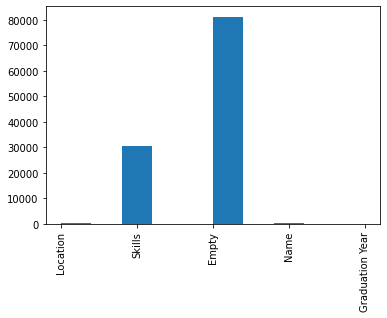

In [37]:
pred_labels = [[id2tag.get(index, "Empty") for index in predictions[i]] for i in range(len(predictions))]
p = plt.hist(np.array(pred_labels).flatten())
plt.xticks(rotation='vertical')
plt.show()

In [38]:
from seqeval.metrics import classification_report
print(classification_report(true_labels, pred_labels))

                    precision    recall  f1-score   support

            NKNOWN       0.00      0.00      0.00         1
               ame       0.00      0.00      0.00       220
ears of Experience       0.00      0.00      0.00        37
             egree       0.00      0.00      0.00       144
        esignation       0.00      0.00      0.00       430
             kills       0.03      0.17      0.05      4704
      mail Address       0.00      0.00      0.00        76
              mpty       0.91      0.72      0.80    103155
           ocation       0.00      0.00      0.00        73
       ollege Name       0.00      0.00      0.00       214
ompanies worked at       0.00      0.00      0.00       470
    raduation Year       0.00      0.00      0.00        58

         micro avg       0.66      0.68      0.67    109582
         macro avg       0.08      0.07      0.07    109582
      weighted avg       0.85      0.68      0.75    109582



In [39]:
from seqeval.metrics import f1_score, classification_report

### Congratulations!

#### Here's what you should remember

- Named-entity recognition (NER) detects and classifies named-entities, and can help process resumes, customer reviews, browsing histories, etc. 
- You must preprocess text data with the corresponding tokenizer to the pretrained model before feeding your input into your Transformer model.